# Making a video of a simulation

Here is an example of generating a video using Pykat and Finesse. This essentially replicates what is done on http://www.gwoptics.org/finesse/examples/video.php. We create a video of cavity scan with some higher order mode content.

In [1]:
import pykat

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

                                              ..-
    PyKat 1.0.18          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [59]:
kat = pykat.finesse.kat()

kat.parseCommands("""
l laser 0.5 0 0 nin
tem laser 1 0 .1 40
gauss g1 laser nin 18m 0
s s1 1m nin nEO1
# Modulator for RF modulation frequency
mod eom1 $fMI .4 1 pm 0 nEO1 nEO2
const fMI 6.3  
s s2 1 nEO2 nMNI1
 
% the following optics were taken from an old model
% of the Virgo north arm cavity
m MNI 0.8819765 0.118 0 nMNI1 nMNI2   
s sN1 2999.5 nMNI2 nMNE1
m MNE 0.99995 50u 0 nMNE1 nMNE2
attr MNE Rc 3602.50
s sN2 1.77 nMNE2 nout
 
# use Hermite-Gauss modes
maxtem 7
# compute cavity eigenmodes
cav cN MNI nMNI2 MNE nMNE1
# computing the beam shape in transmission
beam b1 nout
xaxis b1 x lin -8 8 40
x2axis b1 y lin -8 8 40
""")

Parsing `tem laser 1 0 .1 40` into pykat object not implemented yet, added as extra line.


--------------------------------------------------------------
Running kat - Started at 2017-06-09 18:37:11.513750

Finished in 0.270036 seconds


100% | ETA:  0:00:00 | Calculating                                             

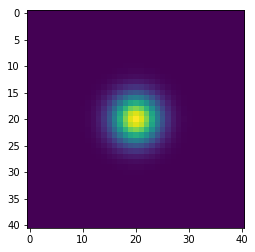

In [61]:
# Check the file runs ok
out = kat.run()

plt.imshow(out['b1'])
plt.show()

It is a good idea to run your model first (especially if it takes a long time to run) to generate the data and store it frame by frame. Afterwards you can then join it together to make a movie. If you do it this way you can experiment with different colormaps, speed, adding labels, etc. without having to re-run your model all the time.

In [63]:
phis = np.linspace(-90, 90, 100)
outs = []

pb = pykat.external.progressbar.ProgressBar()
pb.maxval = len(phis)

for i, phi in enumerate(phis):
    pb.update(i)
    kat.MNE.phi = phi
    kat.verbose = False
    outs.append(kat.run())

 99% (99 of 100) |####################### | Elapsed Time: 0:00:27 ETA:  0:00:00

Now we generate the actual movie from our data.

In [67]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

pcm = plt.pcolormesh(np.zeros((kat.xaxis.steps+1, kat.x2axis.steps+1)), shading='gouraud')

pb = pykat.external.progressbar.ProgressBar()
pb.maxval = len(phis)

def animate(i):
    pb.update(i)
    out = outs[i]
    z = out['b1']
    
    pcm.set_clim((z.min(), z.max()))
    pcm.set_array(z.flatten())
    
    ax.set_title('$\phi = %g deg$' % phis[i])
    
    return (pcm, )

anim = animation.FuncAnimation(fig, animate, frames=len(phis), interval=60, blit=False)

HTML(anim.to_html5_video())

 99% (99 of 100) |####################### | Elapsed Time: 0:00:08 ETA:  0:00:00